---
title: Orthogonal iteration
classes: wide
tags: numerical linear-algebra algorithms eigenvectors eigenvalues
---

A tutorial for an algorithm I implemented in our ``plenoptic`` [PyTorch package](https://github.com/LabForComputationalVision/plenoptic) package to synthesize eigendistortions.
<!--more-->

[[PyTorch code available here]](https://github.com/lyndond/lyndond.github.io/blob/master/code/2021-02-16-orthogonal-iteration.ipynb)

Let's define some random matrix ``C``and compute its top and bottom ``k`` eigenvalue/vectors.

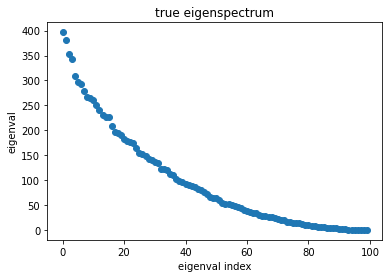

In [29]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

def get_tensor(n=100, rank=100):
    """Method to create random symmetric PSD"""
    A = torch.randn(n, n)
    A = A.T @ A
    _, s, v = torch.svd(A)
    s[rank:] = 0  # 
    A = v @s.diag() @ v.T
    return A

n = 100
C = get_tensor(n=n, rank=100)  # create random PSD matrix

# plot its eigenspectrum
[e, v] = torch.symeig(C, eigenvectors=True)
e_true = torch.sort(e, descending=True)[0]
plt.plot(range(n), e_true,'C0o')
plt.gca().set(title='true eigenspectrum', xlabel='eigenval index', ylabel='eigenval');

## Power iteration
How do we compute the largest eigenvalue/vector of some matrix _without_ explicitly computing its full eigendecomposition/SVD?
We can implement a simple algorithm called the power method or power iteration, $$q_t \leftarrow C q_{t-1}$$ where ``C`` is our (symmetric, positive-semidefinite) matrix in question, and ``q`` is some randomly initialized starting vector. 

``q`` eventually converges to the direction of the top eigenvector of ``C``.
Exactly why that happens lies in the fact that ``C`` can be equivalently written as a weighted sum of outer products of its eigenvectors,

$$C = \lambda_0 v_0v_0^\top + \lambda_1 v_1v_1^\top + \dots + \lambda_n v_nv_n^\top ,$$
where ``lambda`` are the descending-ordered eigenvalues and ``v`` are their corresponding eigenvectors.

**Intuition:** By multiplying ``C`` by ``q``, ``q`` "picks up" a little bit of each eigenvector, scaled by its associated eigenvalue.
Since the top eigenvector ``v0`` will scale ``q`` by the largest amount, after each iteration, ``q`` will incrementally be pulled more and more in the direction of ``v0``.
``q`` will always converge to the direction of the eigenvector with _highest magnitude_ eigenvalue.
If we also normalize ``q`` after each iteration, then the final result after ``t_steps`` iterations will be the top eigenvector ``q=v0``.

## Orthogonal iteration
But what if we want more than just the top 1 eigenvalue/vector and instead seek the top ``k``?
We can initialize ``q`` as a **set** of random vectors instead of just 1, and repeat the same procedure as before.
After each iteration, each vector in ``q`` will again be pulled toward the largest eigenvectors.
Since there's more than one vector in ``q`` though, if we just normalize them after each iteration, then they will **all** converge to the top eigenvector.
What we do instead is both **orthogonalize and normalize** vectors in ``q`` after each iteration.
If we start with ``k`` vectors, then doing this orthogonal iteration procedure will result in the top ``k`` eigenvalue/vectors of the matrix ``C``.


In [2]:
def power_iter(mtx: torch.Tensor,
               k: int,
               shift=0.,  # will explain this below
               t_steps: int = 10000):
    """Based on Algorithm 8.2 in Golub and Van Loan"""
    
    n = mtx.shape[0]  # assumes square 2D tensor
    q = torch.randn(n, k)  # initialize eigenvecs
    
    # main algo
    for _ in tqdm(range(t_steps), desc='Power iter'):
        q = C @ q - (shift*q)  # power iter w/ optional shift (explained below)
        q, _ = torch.qr(q)  # orthonormalize
        
    v = q  # returned eigenvec
    e = torch.stack([u.T @ C @ u for u in q.T]) # returned eigenvals
    return v, e

We can now run our algo to find the top ``k`` eigenval/vecs of ``C``.

In [3]:
k = 2
# top 2 eigenvectors
q_top, e_top = power_iter(C, k=2)    

Power iter: 100%|██████████| 10000/10000 [00:00<00:00, 21828.63it/s]


### How do we find the _smallest_ eigenvalues?
Like I mentioned before, the power method is only effective for _highest magnitude_ eigenvalue/vector pairs.
So a simple trick we can do to compute the bottom ``k`` eigenval/vec pairs is to _shift_ the spectrum of ``C``,

$$(C-\lambda_0 I) q_t = Cq_t - \lambda_0 q_t$$ where $\lambda_0$ our largest computed eigenvalue.
The new matrix $C-\lambda I$ has the **same eigenvectors** as $C$, but its entire spectrum has been _shifted down_ by $\lambda_0$.

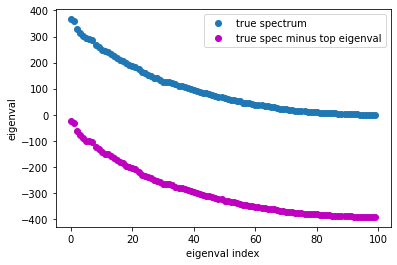

In [27]:
plt.plot(e_true, 'C0o', label='true spectrum')
plt.plot(e_true-e_top[0], 'mo', label='true spec minus top eigenval')
plt.gca().set(xlabel='eigenval index', ylabel='eigenval')
plt.legend();

So now the _highest magnitude_ eigenvalue/vectors pairs are those which used to belong at the bottom end of the spectrum.
So now we know what the mysterious ``shift`` agument in `power_iter()` is for: shifting the spectrum by the top eigenvalue in order to compute the smallest eigenval/vecs.
Since the bottom end of the spectrum is flatter than the top end, we'll have to run for more iterations for the method to converge.

In [10]:
# bottom 2 eigenvectors: shift the spectrum by largest computed eigenvalue
q_bot, e_bot = power_iter(C, k=2, shift=e_top[0], t_steps=100000)

Power iter: 100%|██████████| 100000/100000 [00:04<00:00, 23776.89it/s]


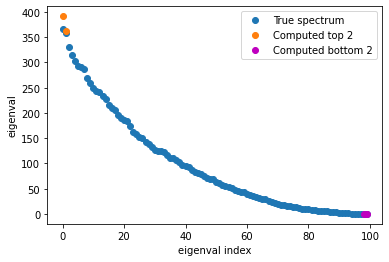

In [28]:
# get ground truth eigenvectors
[e, v] = torch.symeig(C, eigenvectors=True)

plt.plot(range(n), e_true, 'C0o' , label='True spectrum')
plt.plot(range(n)[:k], e_top, 'C1o', label=f'Computed top {k}')
plt.plot(range(n)[-k:], e_bot, 'mo', label=f'Computed bottom {k}')
plt.gca().set(xlabel='eigenval index', ylabel='eigenval')
plt.legend();

## Summary
Our estimated top and bottom ``k`` eigenvalues are quite close to the actual values!

The beauty of these methods is that they _do not_ require explicit access to the matrix, and can be used when you only have access to the matrix implicitly via matrix-vector products (e.g. when it's too massive to store in memory). 
E.g. If you are interested in computing the eigenvectors of the Jacobian of some deep net layer, most ML frameworks don't give you access to the Jacobian explicitly; you only have implicit access to it via vector-Jacobian products.